In [14]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
from api_integrated_llm.data_models.scorer_models import (
    AggegatorOutputModel,
)

In [ ]:
from api_integrated_llm.helpers.file_helper import (
    get_base_model_from_json,
    get_files_in_folder,
)

bins_to_skip = set([0, 1, 6, 7, 8])

model_list = []
is_set = True
is_micro = False
output_file_name = (
    "gold_sequence_length_f1_by_model_slot_set"
    if is_set
    else "gold_sequence_length_f1_by_model_intent_list"
)

current_path = os.path.abspath(os.path.join("."))
file_paths = get_files_in_folder(
    folder_path=os.path.join(current_path, "data", "sequence_length"),
    file_extension="json",
)
for file_path in file_paths:
    obj = get_base_model_from_json(
        file_path=file_path,
        base_model=AggegatorOutputModel,
    )
    model_name = str(file_path).split("/")[-1].split("_")[-1][:-5]
    target_metrics = (
        obj.aggregated_metrics_problem_level["gold_output_length"].slot_set_metrics
        if is_set
        else obj.aggregated_metrics_problem_level[
            "gold_output_length"
        ].intent_counter_metrics
    )
    data = []
    target_list = target_metrics.micro if is_micro else target_metrics.macro
    for k, metrics in target_list.items():
        if int(k) in bins_to_skip:
            continue
        data.append((k, metrics.f1))
    sorted_data = sorted(data, key=lambda datum: datum[0])

    x = list(map(lambda unit: unit[0], sorted_data))
    y = list(map(lambda unit: unit[1], sorted_data))
    model_list.append((model_name, {"x": x, "y": y}))
model_list = sorted(model_list, key=lambda unit: unit[0])

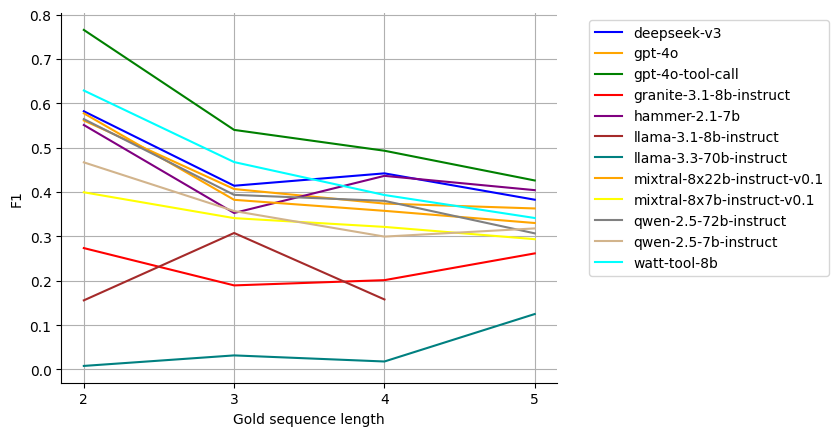

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_prop_cycle(color=["blue", "orange", "green", "red", "purple", "brown", "teal", "orange", "yellow", "grey", "tan", "cyan", "aqua", "olive"])
current_label = ""
current_legends = []
for i, item in enumerate(model_list):
    label = item[0]
    content = item[1]
    current_label = label
    current_legends = content["x"]
    plt.plot(content["x"], content["y"], label=label)
plt.xlabel("Gold sequence length")
plt.ylabel("F1")
ax.set_xticks(current_legends)
ax.set_xticklabels(current_legends)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
current_axes = plt.gca()
current_axes.spines["top"].set_visible(False)
current_axes.spines["right"].set_visible(False)
plt.savefig(f"{output_file_name}.svg", bbox_inches="tight")
plt.savefig(f"{output_file_name}.png", bbox_inches="tight")